### In this notebook we perform federated learning

In federated learning each base station has access only to it's private dataset, however they collaborate together to train a model that has satifactory results on data from any other base station.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch
from matplotlib import pyplot as plt

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("the device currently used is", device)


the device currently used is mps


In [8]:
args = Namespace(
    data_path='../dataset/cluster_split/cluster_5.csv', # dataset
    data_path_test=None , # test dataset
    test_size=0.2, # validation size
    targets=['power_output'], # the target columns
    num_lags= 8, # the number of past observations to feed as input

    identifier='GSRN', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=20, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [9]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/cluster_split/cluster_5.csv', data_path_test=None, test_size=0.2, targets=['power_output'], num_lags=8, identifier='GSRN', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', fl_rounds=20, fraction=1.0, aggregation='fedavg', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [10]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [11]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
seed_all()

### The pre-processing method is almost equivalent to centralized learning. The only difference is that the scaling operations are performed individually on each base station. In contrast, in centralized learning the scaling is performed by considering the combined data from all base stations.

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None

    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [14]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers= make_preprocessing()

/Users/libowen/Library/Python/3.10/lib/python/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
INFO logger 2025-10-20 20:03:39,225 | data_utils.py:393 | Observations info in 570714700000003530
INFO logger 2025-10-20 20:03:39,225 | data_utils.py:394 | 	Total number of samples:  2777
INFO logger 2025-10-20 20:03:39,226 | data_utils.py:395 | 	Number of samples for training: 2222
INFO logger 2025-10-20 20:03:39,226 | data_utils.py:396 | 	Number of samples for validation:  555
INFO logger 2025-10-20 20:03:39,226 | data_utils.py:393 | Observations info in 570714700000013041
INFO logger 2025-10-20 20:03:39,227 | data_utils.py:394 | 	Total number of samples:  2777
INFO logger 2025-10-20 20:03:39,227 | data_utils.py:395 | 	Number of samples for training: 2222
INFO logge

In [15]:
X_train.head()


,cluster_lag-8,power_output_lag-8,age_lag-8,wind_dir_cos_lag-8,wind_dir_sin_lag-8,hour_cos_lag-8,hour_sin_lag-8,temperature_c_lag-8,wind_speed_lag-8,cluster_lag-7,...,cluster_lag-1,power_output_lag-1,age_lag-1,wind_dir_cos_lag-1,wind_dir_sin_lag-1,hour_cos_lag-1,hour_sin_lag-1,temperature_c_lag-1,wind_speed_lag-1,GSRN
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 15:00:00,0.0,0.998794,0.0,0.757519,0.071416,0.146447,0.146447,0.279883,0.948113,0.0,...,0.0,0.854705,0.0,0.999924,0.491274,0.000000,0.500000,0.215743,0.792453,570714700000003530
2019-01-02 18:00:00,0.0,0.998736,0.0,0.865677,0.159001,0.500000,0.000000,0.276968,0.839623,0.0,...,0.0,0.810180,0.0,0.999924,0.491274,0.146447,0.146447,0.230321,0.622642,570714700000003530
2019-01-02 21:00:00,0.0,0.991842,0.0,0.894005,0.192169,0.853553,0.146447,0.271137,0.811321,0.0,...,0.0,0.382627,0.0,0.999315,0.473832,0.500000,0.000000,0.241983,0.523585,570714700000003530
2019-01-03 00:00:00,0.0,0.992359,0.0,0.989074,0.396044,1.000000,0.500000,0.276968,1.000000,0.0,...,0.0,0.146271,0.0,0.987185,0.387524,0.853553,0.146447,0.239067,0.372642,570714700000003530
2019-01-03 03:00:00,0.0,0.991555,0.0,0.995134,0.430413,0.853553,0.853553,0.259475,0.938679,0.0,...,0.0,0.239228,0.0,0.871572,0.165435,1.000000,0.500000,0.224490,0.353774,570714700000003530


In [16]:
power_output_lag_indices = [
    i for i, col in enumerate(X_train.columns)
    if col.startswith("power_output_lag")
]
print("power_output_lag is on the columns:", power_output_lag_indices)

power_output_lag is on the columns: [1, 10, 19, 28, 37, 46, 55, 64]


In [17]:
y_train.head()

,power_output,GSRN
time,,
2019-01-02 15:00:00,0.810180,570714700000003530
2019-01-02 18:00:00,0.382627,570714700000003530
2019-01-02 21:00:00,0.146271,570714700000003530
2019-01-03 00:00:00,0.239228,570714700000003530
2019-01-03 03:00:00,0.338447,570714700000003530


In [18]:
x_scalers, y_scalers

({570714700000003530: MinMaxScaler(),
  570714700000013041: MinMaxScaler(),
  570714700000013034: MinMaxScaler(),
  570714700000003523: MinMaxScaler(),
  570714700000003226: MinMaxScaler(),
  570714700000013638: MinMaxScaler()},
 {570714700000003530: MinMaxScaler(),
  570714700000013041: MinMaxScaler(),
  570714700000013034: MinMaxScaler(),
  570714700000003523: MinMaxScaler(),
  570714700000003226: MinMaxScaler(),
  570714700000013638: MinMaxScaler()})

### Postprocessing in a same manner with centalized learning

In [19]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [20]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [21]:
client_X_train.keys()

dict_keys([570714700000003530, 570714700000013041, 570714700000013034, 570714700000003523, 570714700000003226, 570714700000013638])

In [22]:
client_X_val.keys()

dict_keys([570714700000003530, 570714700000013041, 570714700000013034, 570714700000003523, 570714700000003226, 570714700000013638])

In [23]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: 570714700000003530
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000013041
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000013034
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000003523
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000003226
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

Client: 570714700000013638
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)


In [24]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [25]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [26]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                #   exogenous_dim=exogenous_dim,
                    exogenous_dim=0,
                  seed=args.seed)

9 0


In [27]:
model

LSTM(
  (lstm): LSTM(9, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Fit function initiates the training process of every base station local model and then performs parameters aggregation on a central server for N specified federated epochs.

In [28]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=  [1], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
 
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                #exogenous_data=tmp_exogenous_data_train,
                exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                # exogenous_data=tmp_exogenous_data_val,
                 exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [29]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

The traning takes 1m 49s

In [30]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2025-10-20 20:03:39,594 | server.py:62 | Initializing client manager...
INFO logger 2025-10-20 20:03:39,595 | server.py:69 | Registering clients...
INFO logger 2025-10-20 20:03:39,595 | client_manager.py:66 | Registered client with id: 570714700000003530
INFO logger 2025-10-20 20:03:39,595 | client_manager.py:66 | Registered client with id: 570714700000013041
INFO logger 2025-10-20 20:03:39,596 | client_manager.py:66 | Registered client with id: 570714700000013034
INFO logger 2025-10-20 20:03:39,596 | client_manager.py:66 | Registered client with id: 570714700000003523
INFO logger 2025-10-20 20:03:39,596 | client_manager.py:66 | Registered client with id: 570714700000003226
INFO logger 2025-10-20 20:03:39,596 | client_manager.py:66 | Registered client with id: 570714700000013638
INFO logger 2025-10-20 20:03:39,596 | server.py:73 | Client manager initialized!
INFO logger 2025-10-20 20:03:39,597 | server.py:55 | Aggregation algorithm: FedAvg()
INFO logger 2025-10-20 20:03:39,

In [31]:
global_model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0007,  0.1237, -0.0727,  ...,  0.0489,  0.1105,  0.0699],
                      [ 0.0234,  0.0760, -0.0174,  ...,  0.0417,  0.0501,  0.1423],
                      [-0.0599,  0.0573,  0.0321,  ...,  0.1187,  0.1459,  0.2250],
                      ...,
                      [-0.0457,  0.0453, -0.0705,  ...,  0.1699, -0.0034,  0.2076],
                      [ 0.0744,  0.0953, -0.0551,  ..., -0.0293, -0.0353,  0.0314],
                      [-0.0855, -0.0637, -0.0668,  ...,  0.0866, -0.0616,  0.0031]])),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0762,  0.1336,  0.0100,  ..., -0.1006, -0.0830,  0.1257],
                      [-0.0416,  0.0464, -0.0279,  ...,  0.0021,  0.0582,  0.0132],
                      [-0.1218,  0.0283, -0.0680,  ..., -0.1520, -0.0541,  0.1045],
                      ...,
                      [ 0.0171,  0.1671,  0.0054,  ..., -0.0473, -0.0586,  0.0932],
                      [-0.0549,  

In [32]:
history


History (client, train losses):
	570714700000003523: {1: 0.00027817172690714495, 2: 0.00023388133368302597, 3: 0.00020213351818853224, 4: 0.00017751129798409415, 5: 0.0001660736125002951, 6: 0.00016085296118835554, 7: 0.00015356503035822696, 8: 0.00015179680739449506, 9: 0.00015017847562513324, 10: 0.00014957238717278921, 11: 0.0001485302287987631, 12: 0.00014767735563857984, 13: 0.0001470217474525106, 14: 0.00014659757797405218, 15: 0.00014638497940893096, 16: 0.0001459878014590736, 17: 0.0001456089178562945, 18: 0.00014522317910521497, 19: 0.00014487949015729148, 20: 0.0001445078514364919}
	570714700000003530: {1: 0.00022845724433519167, 2: 0.00017377469436683656, 3: 0.00016619831234445526, 4: 0.00014743584884598164, 5: 0.00013936673692329144, 6: 0.00013336095817609208, 7: 0.00013212350789413812, 8: 0.00013194381322058856, 9: 0.00013308840224985453, 10: 0.00012969280119443544, 11: 0.00012781325258254036, 12: 0.00012719727145691335, 13: 0.00013016829331924544, 14: 0.00012986457952093

In [33]:
import h5py
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# extract MinMaxScaler attributes
def get_minmax_attrs(scaler: MinMaxScaler):
    return {
        "min_": scaler.min_,
        "scale_": scaler.scale_,
        "data_min_": scaler.data_min_,
        "data_max_": scaler.data_max_,
        "data_range_": scaler.data_range_,
        "n_features_in_": np.array([scaler.n_features_in_]),
        "n_samples_seen_": np.array([scaler.n_samples_seen_]),
        "feature_names_in_": getattr(scaler, "feature_names_in_", None)
    }

# process a dict of MinMaxScalers
def build_scaler_state_dict(scaler_dict):
    state_dict = {}
    for client_id, scaler in scaler_dict.items():
        state_dict[client_id] = get_minmax_attrs(scaler)
    return state_dict

# save the scalers to h5 file
class ScalerSerializer:
    def __init__(self, x_scaler_state, y_scaler_state, save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            # save x_scalers
            x_group = f.create_group("x_scaler", track_order=True)
            for client_id, attrs in self.x_scaler.items():
                client_group = x_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

            # save y_scalers
            y_group = f.create_group("y_scaler", track_order=True)
            for client_id, attrs in self.y_scaler.items():
                client_group = y_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

x_scaler_attrs = build_scaler_state_dict(x_scalers)
y_scaler_attrs = build_scaler_state_dict(y_scalers)

scaler_serializer = ScalerSerializer(
    x_scaler_attrs,
    y_scaler_attrs,
    save_path="model_checkpoint/scalers_cluster5.h5"
)
scaler_serializer.save()

print(" Scalers saved to model_checkpoint/scalers_cluster5.h5")

 Scalers saved to model_checkpoint/scalers_cluster5.h5


In [34]:
import matplotlib.pyplot as plt

def plot_fl_training_metrics(history):
    metrics_to_plot = ["MSE", "RMSE", "MAE", "R^2", "NRMSE"]
    rounds = list(range(1, len(next(iter(history.global_test_metrics.values()))) + 1))

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.global_test_metrics:
            plt.subplot(2, 3, i)
            plt.plot(rounds, history.global_test_metrics[metric], marker='o', label=f"Test {metric.upper()}")
            if metric in history.global_train_metrics:
                plt.plot(rounds, history.global_train_metrics[metric], marker='x', label=f"Train {metric.upper()}")
            plt.title(metric.upper())
            plt.xlabel("Round")
            plt.ylabel(metric.upper())
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
for cid in client_y_val:
    print(f"{cid}: min={client_y_val[cid].min()}, max={client_y_val[cid].max()}")

570714700000003530: min=0.0, max=1.0098817348480225
570714700000013041: min=0.0, max=0.9950849413871765
570714700000013034: min=0.0, max=0.9996465444564819
570714700000003523: min=0.0, max=0.9974273443222046
570714700000003226: min=0.0, max=0.9947450757026672
570714700000013638: min=0.0, max=0.996353268623352


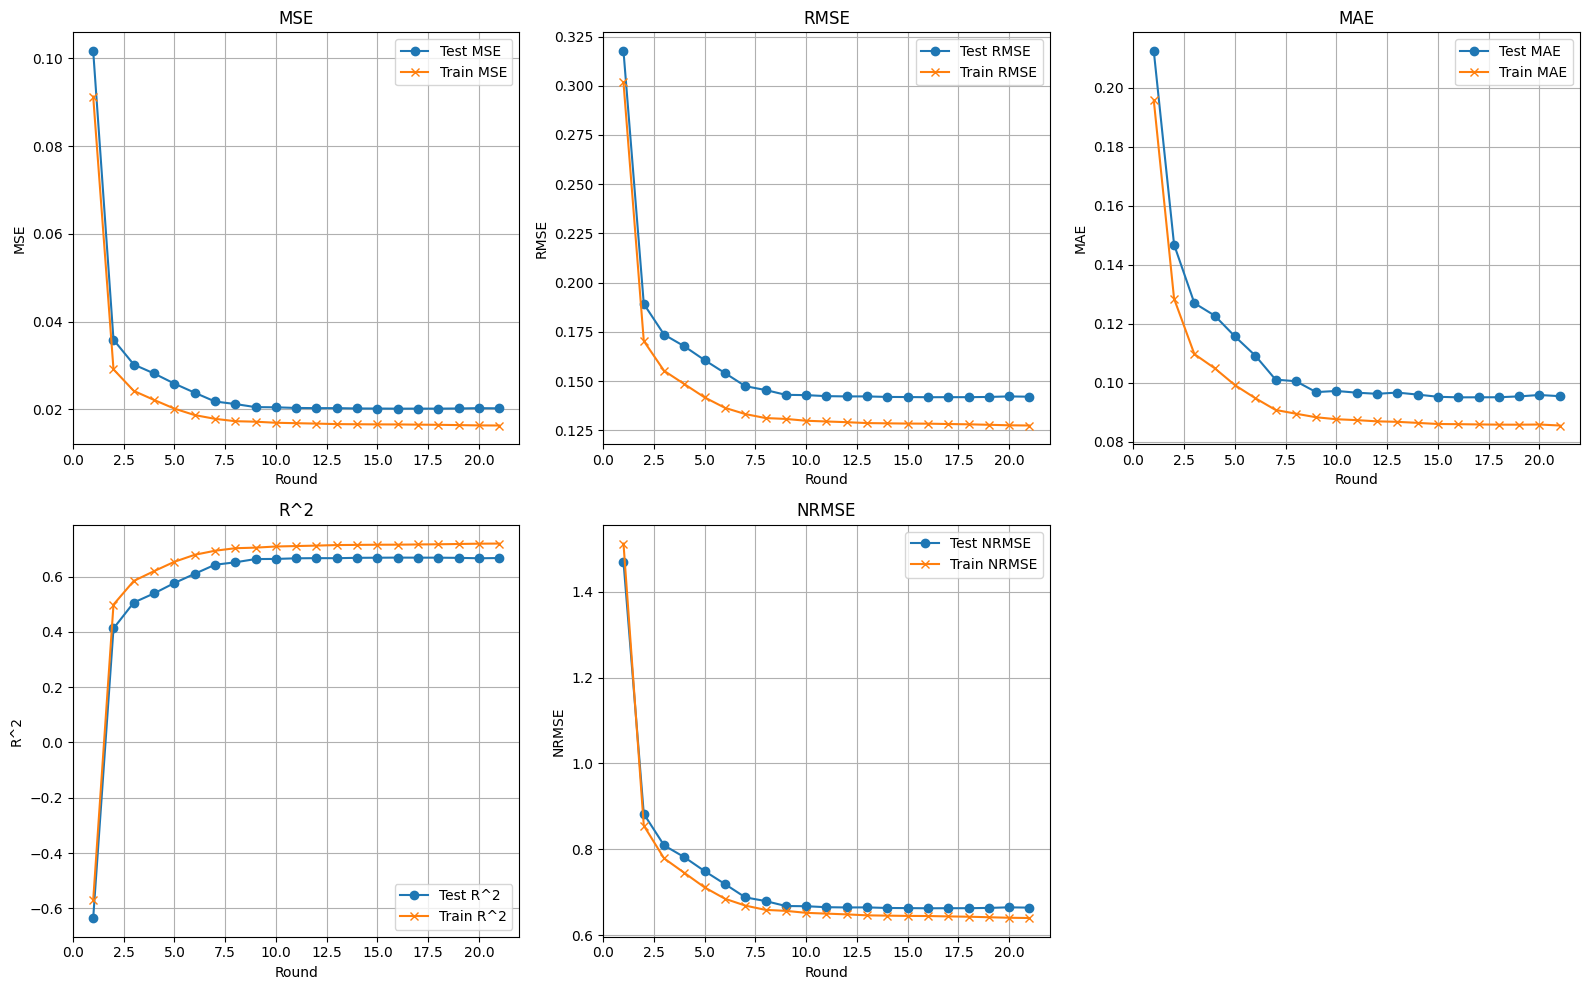

In [36]:
plot_fl_training_metrics(history)

In [37]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [38]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

### During the inference stage we inverse the transformations we applied during preprocessing

In [39]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scalers used to transform the targets
    idxs=[1],
    apply_round=True, # round to closest integer
    round_dimensions=[0], # the dimensions to apply rounding
    plot=True, # plot predictions
    plot_clients: list = None,  # 指定要画图的client，比如 ['GSRN_001', 'GSRN_002']
    max_plot_clients: int = 5,
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            if (plot_clients is not None and cid not in plot_clients):
                continue
            if plot_clients is None and cids.index(cid) >= max_plot_clients:
                continue

            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on 570714700000003530
Prediction on 570714700000013041
Prediction on 570714700000013034
Prediction on 570714700000003523
Prediction on 570714700000003226
Prediction on 570714700000013638


INFO logger 2025-10-20 20:05:52,506 | helpers.py:60 | Metrics for dimension: 0
	mse: 41646.44921875, rmse: 204.07461679187347, mae: 132.551513671875, r^2: 0.7343051433563232, nrmse: 0.6146360266766034
INFO logger 2025-10-20 20:05:52,510 | helpers.py:60 | Metrics for dimension: 0
	mse: 47063.53125, rmse: 216.94130830710873, mae: 143.2657928466797, r^2: 0.732876181602478, nrmse: 0.5763236619312959



Final Prediction on 570714700000003530 (Inference Stage)
[Train]: mse: 41646.44921875, rmse: 204.07461679187347, mae 132.551513671875, r2: 0.7343051433563232, nrmse: 0.6146360266766034
[Val]: mse: 47063.53125, rmse: 216.94130830710873, mae 143.2657928466797, r2: 0.732876181602478, nrmse: 0.5763236619312959




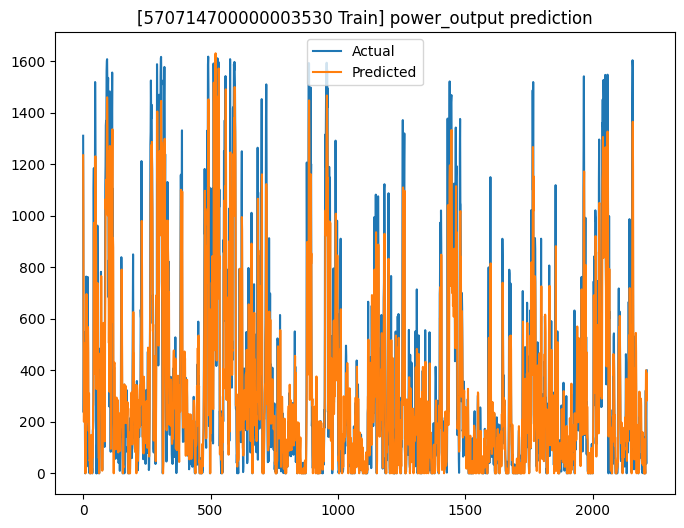

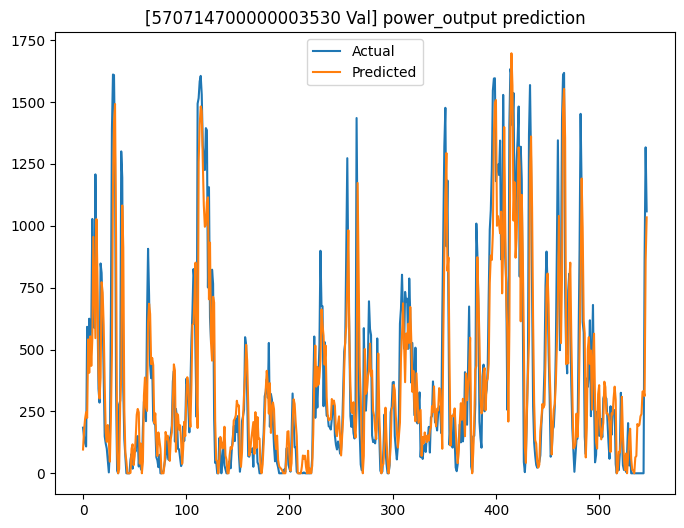

INFO logger 2025-10-20 20:05:52,644 | helpers.py:60 | Metrics for dimension: 0
	mse: 38197.75, rmse: 195.4424467714217, mae: 126.35977172851562, r^2: 0.7089583873748779, nrmse: 0.6790341283394824
INFO logger 2025-10-20 20:05:52,645 | helpers.py:60 | Metrics for dimension: 0
	mse: 48080.828125, rmse: 219.27340952564222, mae: 143.16213989257812, r^2: 0.5722465515136719, nrmse: 0.8186480438125574



Final Prediction on 570714700000013041 (Inference Stage)
[Train]: mse: 38197.75, rmse: 195.4424467714217, mae 126.35977172851562, r2: 0.7089583873748779, nrmse: 0.6790341283394824
[Val]: mse: 48080.828125, rmse: 219.27340952564222, mae 143.16213989257812, r2: 0.5722465515136719, nrmse: 0.8186480438125574




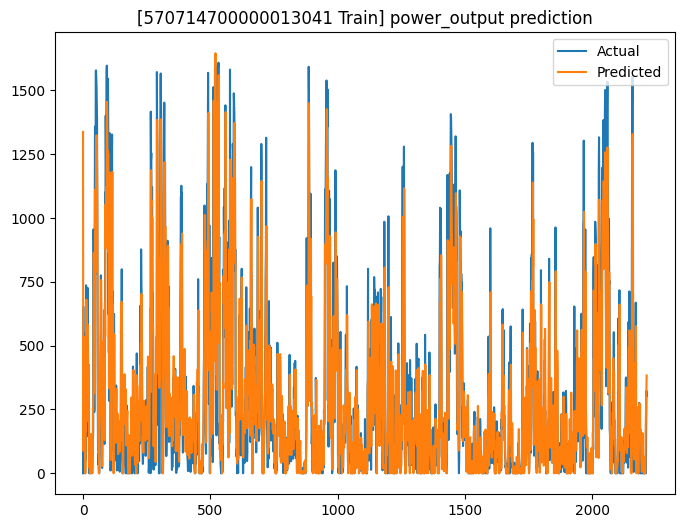

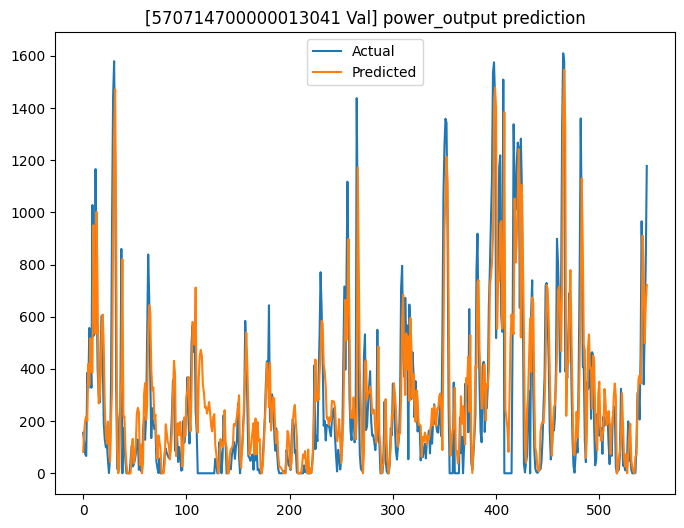

INFO logger 2025-10-20 20:05:52,770 | helpers.py:60 | Metrics for dimension: 0
	mse: 43129.97265625, rmse: 207.67756897712857, mae: 133.9230499267578, r^2: 0.7001226544380188, nrmse: 0.6865814016731312
INFO logger 2025-10-20 20:05:52,772 | helpers.py:60 | Metrics for dimension: 0
	mse: 50890.91015625, rmse: 225.59013754206987, mae: 145.06015014648438, r^2: 0.6792207360267639, nrmse: 0.6366942152066092



Final Prediction on 570714700000013034 (Inference Stage)
[Train]: mse: 43129.97265625, rmse: 207.67756897712857, mae 133.9230499267578, r2: 0.7001226544380188, nrmse: 0.6865814016731312
[Val]: mse: 50890.91015625, rmse: 225.59013754206987, mae 145.06015014648438, r2: 0.6792207360267639, nrmse: 0.6366942152066092




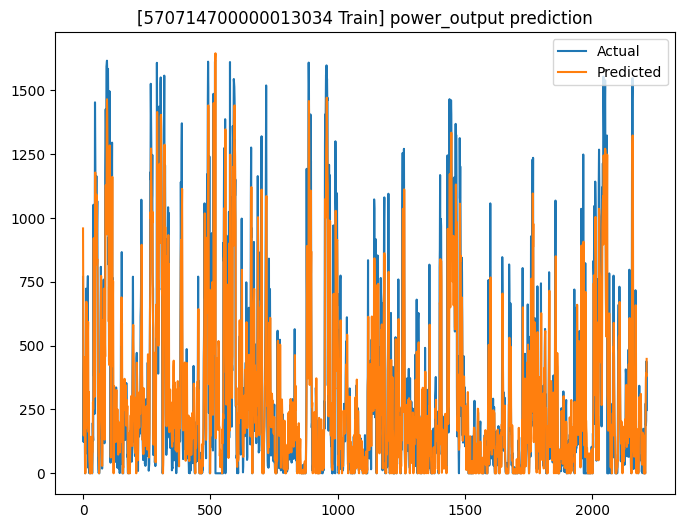

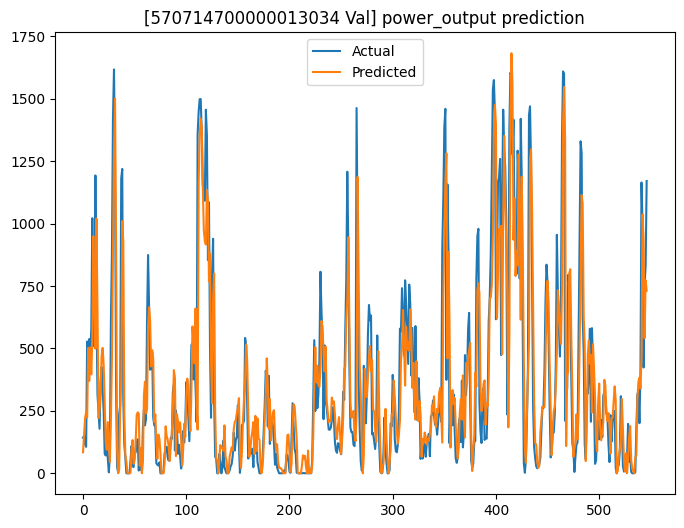

INFO logger 2025-10-20 20:05:52,898 | helpers.py:60 | Metrics for dimension: 0
	mse: 48626.13671875, rmse: 220.51334816457256, mae: 142.17019653320312, r^2: 0.7281627058982849, nrmse: 0.639685685157357
INFO logger 2025-10-20 20:05:52,899 | helpers.py:60 | Metrics for dimension: 0
	mse: 55795.78125, rmse: 236.21130635513617, mae: 154.58128356933594, r^2: 0.6902664303779602, nrmse: 0.6438520802402449



Final Prediction on 570714700000003523 (Inference Stage)
[Train]: mse: 48626.13671875, rmse: 220.51334816457256, mae 142.17019653320312, r2: 0.7281627058982849, nrmse: 0.639685685157357
[Val]: mse: 55795.78125, rmse: 236.21130635513617, mae 154.58128356933594, r2: 0.6902664303779602, nrmse: 0.6438520802402449




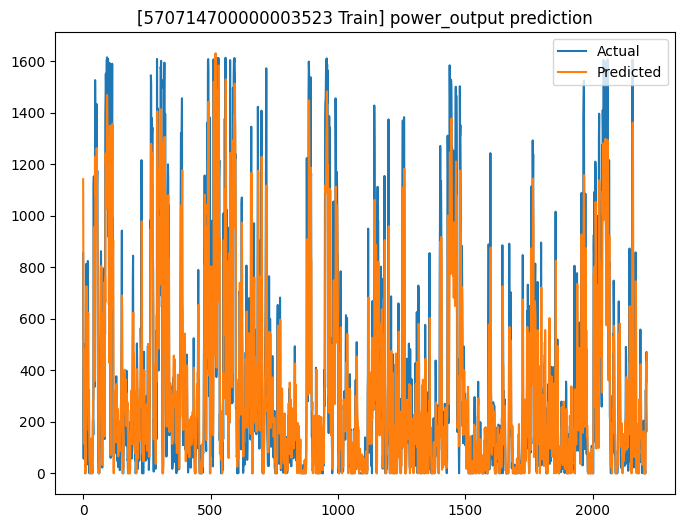

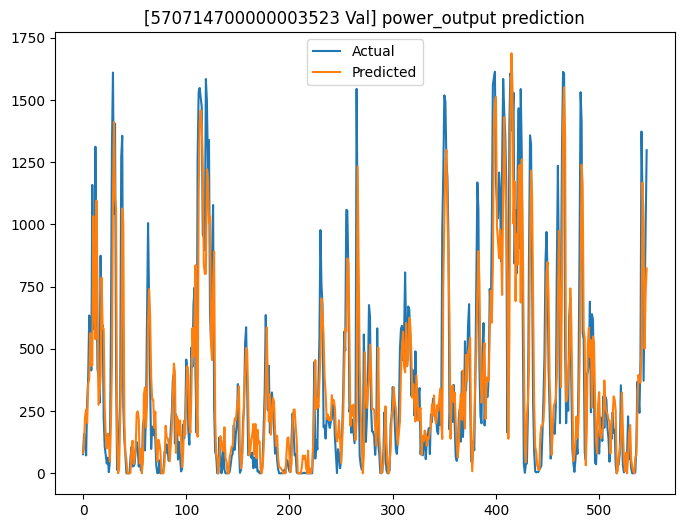

INFO logger 2025-10-20 20:05:53,032 | helpers.py:60 | Metrics for dimension: 0
	mse: 48745.28515625, rmse: 220.783344381432, mae: 143.49317932128906, r^2: 0.7112704515457153, nrmse: 0.6427086428353376
INFO logger 2025-10-20 20:05:53,035 | helpers.py:60 | Metrics for dimension: 0
	mse: 57355.0859375, rmse: 239.48921883354166, mae: 157.14810180664062, r^2: 0.6664193868637085, nrmse: 0.6806586158318695



Final Prediction on 570714700000003226 (Inference Stage)
[Train]: mse: 48745.28515625, rmse: 220.783344381432, mae 143.49317932128906, r2: 0.7112704515457153, nrmse: 0.6427086428353376
[Val]: mse: 57355.0859375, rmse: 239.48921883354166, mae 157.14810180664062, r2: 0.6664193868637085, nrmse: 0.6806586158318695




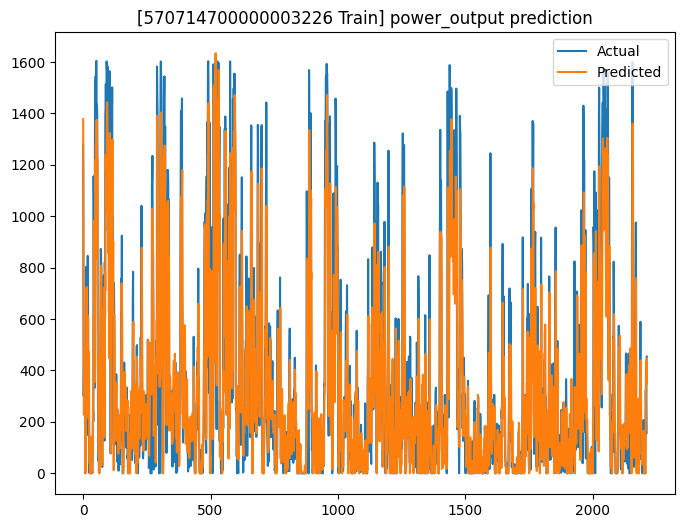

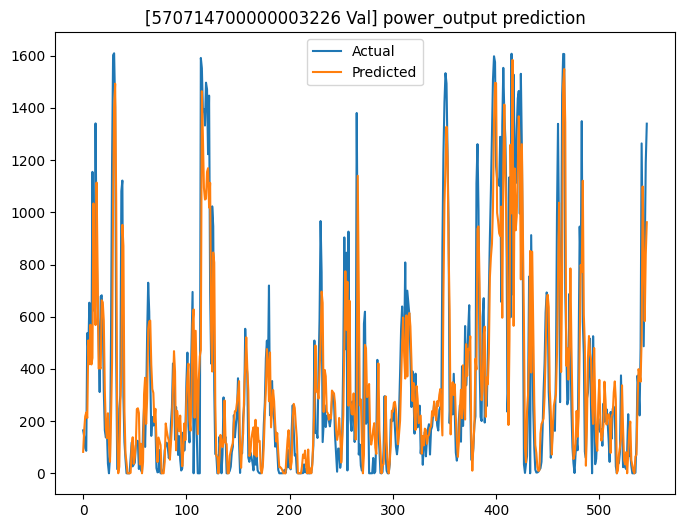

INFO logger 2025-10-20 20:05:53,174 | helpers.py:60 | Metrics for dimension: 0
	mse: 34972.41015625, rmse: 187.00911784255334, mae: 128.22024536132812, r^2: 0.7393008470535278, nrmse: 0.5711859500344029
INFO logger 2025-10-20 20:05:53,176 | helpers.py:60 | Metrics for dimension: 0
	mse: 55553.2109375, rmse: 235.69728665705932, mae: 162.6846466064453, r^2: 0.6803920269012451, nrmse: 0.6097503713515039



Final Prediction on 570714700000013638 (Inference Stage)
[Train]: mse: 34972.41015625, rmse: 187.00911784255334, mae 128.22024536132812, r2: 0.7393008470535278, nrmse: 0.5711859500344029
[Val]: mse: 55553.2109375, rmse: 235.69728665705932, mae 162.6846466064453, r2: 0.6803920269012451, nrmse: 0.6097503713515039




In [40]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers
)